In [ ]:
!pip install librosa

In [85]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,Flatten,Dropout,Activation
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

In [ ]:
audio_datset_path="/content/drive/MyDrive/Colab Notebooks/UrbanSound8K/audio/"
filename= "/content/drive/MyDrive/Colab Notebooks/UrbanSound8K/audio/fold4/107653-9-0-18.wav"

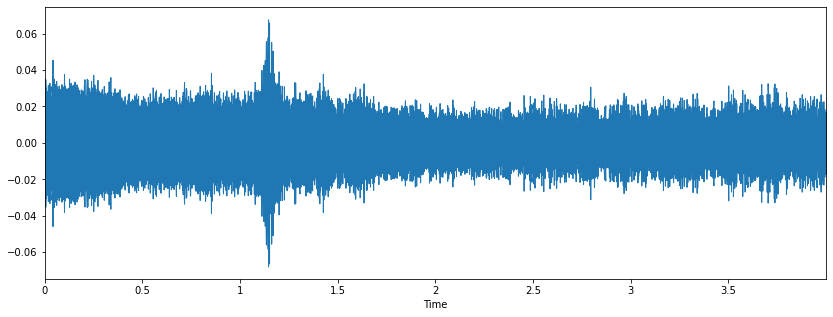

In [ ]:
plt.figure(figsize=(14,5))
data,sample_rate=librosa.load(filename)
librosa.display.waveplot(data,sample_rate)


In [ ]:
sample_rate

22050

In [ ]:
data

array([ 0.00557869,  0.01876141,  0.01414782, ..., -0.00630127,
       -0.00023995,  0.00382148], dtype=float32)

In [ ]:
metadata=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/UrbanSound8K/metadata/UrbanSound8K.csv")

In [ ]:
# To See Number Of Samples In Each Categories Of Voice

metadata['class'].value_counts()

dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

In [95]:
#To Extract Class From Dummy Variable

sound_class=metadata["class"].unique()

In [ ]:
def extract_features(file):
  audio,sample_rate=librosa.load(file,res_type="kaiser_fast")
  mfccs_features=librosa.feature.mfcc(y=audio,sr=sample_rate,n_mfcc=40)
  mfccs_scaled_features=np.mean(mfccs_features.T,axis=0)

  return mfccs_scaled_features


In [33]:
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
  file_name=os.path.join(os.path.abspath(audio_datset_path),'fold'+str(row["fold"])+"/",str(row["slice_file_name"]))
  final_class_labels=row["class"]
  data=extract_features(file_name)
  extracted_features.append([data,final_class_labels])


3555it [47:14,  1.28it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1323
  n_fft, y.shape[-1]
8326it [1:50:28,  1.45it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1103
  n_fft, y.shape[-1]
8329it [1:50:31,  1.18it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1523
  n_fft, y.shape[-1]
8732it [1:55:40,  1.26it/s]


In [35]:
extracted_features_df=pd.DataFrame(extracted_features,columns=["features","class"])

In [36]:
extracted_features_df.head

<bound method NDFrame.head of                                                features             class
0     [-215.79301, 71.66612, -131.81377, -52.09133, ...          dog_bark
1     [-424.68677, 110.56227, -54.148235, 62.01074, ...  children_playing
2     [-459.56467, 122.800354, -47.92471, 53.265705,...  children_playing
3     [-414.55377, 102.896904, -36.66495, 54.18041, ...  children_playing
4     [-447.397, 115.0954, -53.809113, 61.60859, 1.6...  children_playing
...                                                 ...               ...
8727  [-399.2257, 136.81903, -51.964222, 37.02399, -...          car_horn
8728  [-346.72733, 87.48847, -46.265022, 52.748833, ...          car_horn
8729  [-304.61316, 112.6199, -47.161945, 37.00349, -...          car_horn
8730  [-344.71423, 126.75814, -56.17717, 36.070927, ...          car_horn
8731  [-315.93384, 95.67589, -38.047768, 47.50074, -...          car_horn

[8732 rows x 2 columns]>

In [39]:
X=np.array(extracted_features_df["features"].tolist())
Y=np.array(extracted_features_df["class"].tolist())

In [42]:
Y=np.array(pd.get_dummies(Y))

In [46]:
Y.shape

(8732, 10)

In [75]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=0)

In [76]:
num_labels=Y.shape[1]


**ANN Model**

In [77]:
model=Sequential()

#First Layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation("relu"))
model.add(Dropout(0.5))

#Second Layer
model.add(Dense(100))
model.add(Activation("relu"))
model.add(Dropout(0.5))

#Third Layer
model.add(Dense(100))
model.add(Activation("relu"))
model.add(Dropout(0.5))

#Final Layer
model.add(Dense(num_labels))
model.add(Activation("softmax"))

In [78]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 100)               4100      
                                                                 
 activation_9 (Activation)   (None, 100)               0         
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_11 (Dense)            (None, 100)               10100     
                                                                 
 activation_10 (Activation)  (None, 100)               0         
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_12 (Dense)            (None, 100)              

In [80]:
model.compile(loss="categorical_crossentropy",metrics=["accuracy"],optimizer="adam")

In [88]:
num_epochs=100
num_batch_size=132
checkpointer=ModelCheckpoint(filepath="saved_models/audio_classification.hdf5",verbose=1,save_best_only="true")
model.fit(X_train,Y_train,epochs=num_epochs,batch_size=num_batch_size)

Epoch 1/100
53/53 [==============================] - 0s 3ms/step - loss: 0.8985 - accuracy: 0.7079
Epoch 2/100
53/53 [==============================] - 0s 3ms/step - loss: 0.8986 - accuracy: 0.7038
Epoch 3/100
53/53 [==============================] - 0s 3ms/step - loss: 0.8908 - accuracy: 0.7082
Epoch 4/100
53/53 [==============================] - 0s 3ms/step - loss: 0.8824 - accuracy: 0.7065
Epoch 5/100
53/53 [==============================] - 0s 3ms/step - loss: 0.8980 - accuracy: 0.7049
Epoch 6/100
53/53 [==============================] - 0s 3ms/step - loss: 0.8743 - accuracy: 0.7128
Epoch 7/100
53/53 [==============================] - 0s 3ms/step - loss: 0.8883 - accuracy: 0.7032
Epoch 8/100
53/53 [==============================] - 0s 3ms/step - loss: 0.8866 - accuracy: 0.7081
Epoch 9/100
53/53 [==============================] - 0s 3ms/step - loss: 0.8869 - accuracy: 0.7071
Epoch 10/100
53/53 [==============================] - 0s 3ms/step - loss: 0.9031 - accuracy: 0.7068
Epoch 11/

In [89]:
test_accuracy=model.evaluate(X_test,Y_test)
print(test_accuracy[1])

55/55 [==============================] - 0s 2ms/step - loss: 0.6585 - accuracy: 0.8037
0.803663432598114
